In [3]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9
import DiaSourceTools as DSTools

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

import numpy as np

from astropy.table import Table

import sncosmo

%matplotlib inline

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [30]:
#This method allows to find matches pair to pair. Input is the list of catalogs with their visit id.
def find_paired_matches(subtr_visits):

    paired_matches = []
    for i, (visit, diaSrcs) in enumerate(subtr_visits):

        if i+1 == len(subtr_visits):
            break

        next_visit, next_diaSrcs = subtr_visits[i+1]

        match = afwTable.matchRaDec(diaSrcs, next_diaSrcs, afwGeom.Angle(1./3600., afwGeom.degrees)) 
        for m in match:
            paired_matches.append((visit, next_visit, m))
    return paired_matches

def source_distance(src1, src2):
    ra, dec = src1['coord_ra'], src1['coord_dec']
    ra2, dec2 = src2['coord_ra'], src2['coord_dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def add_pair_to_list(light_curves, pair):
    
    #print pair
    for lc in light_curves:
        v, s = pair[0]
        if lc[-1][-1].getId() == pair[0][-1].getId():
            
            lc.append(pair[-1])
            return True
        elif source_distance(lc[-1][-1], pair[0][-1]) < 1:
            lc.append(pair[0])
            lc.append(pair[-1])
            return True
    light_curves.append(pair)
    return False

def add_pair_to_list2(light_curves, pair):
    
    #print pair
    for lc in light_curves:
        v, s = pair[0]
        if lc[-1][-1].getId() == pair[0][-1].getId():
            
            lc.append(pair[-1])
            return True
    light_curves.append(pair)
    return False

def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves

#The input is a list of tuples for all matches between catalogs.
def create_light_curves(paired_matches):

    light_curves = []
    c_paired_matches = list(paired_matches)

    while len(c_paired_matches)>0:
        visit, n_visit, match = c_paired_matches.pop(0)
        points = []
        points.append((visit,match.first))
        points.append((n_visit,match.second))
        add_pair_to_list(light_curves, points) 
        
    return light_curves

def fill_gaps_on_curves(light_curves):
    light_cs_copy = list(light_curves)


    for i, lc in enumerate(light_cs_copy):
        j=i+1
        while j < len(light_cs_copy):
            compar_lc = light_cs_copy[j]


            if source_distance(lc[-1][-1], compar_lc[0][-1]) < 1:
                #print "match"
                lc.extend(compar_lc)
                light_cs_copy.pop(j)
            j+=1
    return light_cs_copy
    
            
def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """
        
    bandpasses = ['r']
  
        
    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []

  
    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(visit[-1])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_PeakLikelihoodFlux_flux'])
        lightcurve['flux_error'].append(src['base_PeakLikelihoodFlux_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve  


   

In [31]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit', 'date'],dataId={'filter':'r'})
visits.remove((849685, '2006-05-24'))
visits.remove((849686, '2006-05-24'))

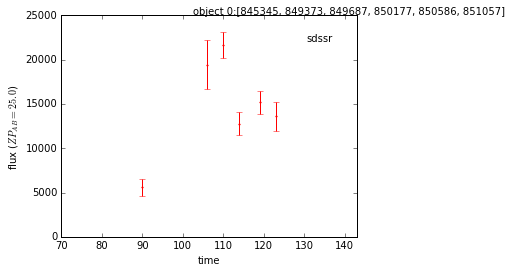

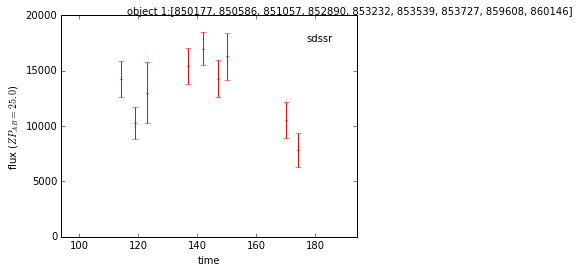

In [32]:
#Pre-cond: Visits are in chronological order
subtr_visits = []
dates = []

for visit, date in visits:
    #We check if there is actually data for the given visit (due to butler limitations) and we chose the first visit for each date
    if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':14}) and date not in dates:
       
        #Keeping the dates in terms of days
        if len(dates) == 0:
            days=0
        else:
            days = np.datetime64(date)-np.datetime64(dates[0])
            days = days.item().days
            
        dates.append(date)   
        
        #Recover Difference Exposure and DiaSources
        diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':14})
        diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':14})
        
        class_diaSrcs = diaSrcs.copy()
        class_diaSrcs.clear()
        
        #We select DiaSources above 5 Sigma
        fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

        m_sigma = np.mean(sigmas)
        t_sigma = 5*m_sigma

        sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")
        
        #Here we add conditions on the DiaSources set (for instance, no diaSources with negative footprints)
        for source in sources:
            try:
                stamp = DSTools.get_stamp(source, diffExp)
                stamp_clone = stamp.clone()

                results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
                negFps = len(results.fpSets.negative.getFootprints())
                posFps = len(results.fpSets.positive.getFootprints())
    
                if negFps == 0:
                #if True:
                    class_diaSrcs.addNew()
                    class_diaSrcs.append(source)
                    
                    
            except Exception, e:
                pass
                #print e
        subtr_visits.append(((visit, days), class_diaSrcs))      
        
paired_matches = find_paired_matches(subtr_visits)
light_curves = create_light_curves(paired_matches)
#light_curves = fill_gaps_on_curves(light_curves)

t_light_curves = threshold_light_curves(light_curves, 3)

for i, light_c in enumerate(t_light_curves):
    lc = build_lightcurve(light_c)
    #print lc
    #visualize_lightcurve(lc, color='red')
    lc_visits = [visit[0] for visit, data in light_c ]
    #print visits
    fig = sncosmo.plot_lc(lc, color='red', xfigsize=10)
    axes = fig.get_axes()
    xlim = axes[0].get_xlim()
    axes[0].set_xlim(xlim[0]-10, xlim[1]+10)
    fig.suptitle("object "+str(i)+":"+str(lc_visits))
    fig.show()


In [33]:
i = 1
for tl in t_light_curves:
    try:
        dataid_list = [{'visit': visit[0] , 'filter':'r' , 'ccd':14}  for visit, data in tl]
        source = tl[0][-1]
        DSTools.get_time_mosaic(butler, dataid_list, source, frame=i, equalize=True, title="object n. "+str(i))
        ds9.setMaskTransparency(100, frame=i)
        i+=1
    except Exception, e:
        
        i+=1
        print e
    